# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal


### Import python packages

In [1]:
from ibovespa.utils import load_config
from ibovespa.model_training import train_model, read_feature_table
from ibovespa.model_evaluation import model_prediction, calculate_metrics, benchmark_model, graphical_evaluation

### Load Configurations

In [2]:
config = load_config()

### Model Training

#### Read feature table from disk

In [3]:
file = config["feature_engineering"]["feature_file"]
target = config["model_training"]["target"]
variables = config["model_training"]["variables"]


feature_table = read_feature_table(file, target, variables)

In [4]:
feature_table.head()

,date,group,target,lags,delta_sign,weekday_vector,lag_pct_IBOV,lag_pct_ITUB4,lag_pct_BBDC4,lag_pct_VALE3,lag_pct_PETR4,lag_pct_PETR3,lag_pct_ABEV3,lag_pct_BBAS3,lag_pct_B3SA3,lag_pct_ITSA4
0,2019-08-20,train,[0.5656421760170627],"[0.5689679780470137, 0.5735056107761373, 0.563...","[-1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 0]","[0, 1, 0, 0, 0, 0, 0]","[-0.007912098232103926, 0.017899818373004583, ...","[-0.0043667457887850425, -0.018571472167968728...","[-0.014427461270432151, 0.0021084475351151877,...","[-0.0009154749848315769, -0.004556864108469893...","[0.005018855708875503, -0.013206756123392172, ...","[0.013646725618057243, -0.00452833355597726, -...","[0.01111116381269106, 0.00638971924905718, -0....","[-0.019680684893740308, -0.0026172068893850486...","[0.022471910112359605, 0.026528294494991167, -...","[-0.017585952278473482, -0.022656246682163372,..."
1,2019-08-21,train,[0.5923024513988566],"[0.5656421760170627, 0.5689679780470137, 0.573...","[-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0]","[0, 0, 1, 0, 0, 0, 0]","[-0.005845323741007102, -0.007912098232103926,...","[-0.011111142094681448, -0.0043667457887850425...","[-0.009759063989821737, -0.014427461270432151,...","[0.004352774801080761, -0.0009154749848315769,...","[-0.00041615599650790536, 0.005018855708875503...","[-0.009349289534027028, 0.013646725618057243, ...","[-0.008895869746956442, 0.01111116381269106, 0...","[-0.000892280033315429, -0.019680684893740308,...","[0.005714248824905566, 0.022471910112359605, 0...","[-0.01545968925736707, -0.017585952278473482, ..."
2,2019-08-22,train,[0.5762658918131411],"[0.5923024513988566, 0.5656421760170627, 0.568...","[1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0.04713275726630006, -0.005845323741007102, -...","[0.007687821956730012, -0.011111142094681448, ...","[0.019710548468896638, -0.009759063989821737, ...","[0.007071199183668719, 0.004352774801080761, -...","[0.05953373346891766, -0.00041615599650790536,...","[0.05322762776877865, -0.009349289534027028, 0...","[-0.007391831734393173, -0.008895869746956442,...","[0.05715555941652761, -0.000892280033315429, -...","[0.0013112188700141747, 0.005714248824905566, ...","[0.012396662297629923, -0.01545968925736707, -..."
3,2019-08-23,train,[0.544704434492472],"[0.5762658918131411, 0.5923024513988566, 0.565...","[-1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 0]","[0, 0, 0, 0, 1, 0, 0]","[-0.027074950555820765, 0.04713275726630006, -...","[-0.0158450964352731, 0.007687821956730012, -0...","[-0.012987079645871868, 0.019710548468896638, ...","[-0.0058890629047445575, 0.007071199183668719,...","[-0.009037384781531821, 0.05953373346891766, -...","[-0.00967743589445591, 0.05322762776877865, -0...","[-0.017553188143514586, -0.007391831734393173,...","[-0.014783462952480675, 0.05715555941652761, -...","[-0.007638552519690034, 0.0013112188700141747,...","[-0.01632651504205196, 0.012396662297629923, -..."
4,2019-08-26,train,[0.5280484947716239],"[0.544704434492472, 0.5762658918131411, 0.5923...","[-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0]","[1, 0, 0, 0, 0, 0, 0]","[-0.05476891443525389, -0.027074950555820765, ...","[-0.01162788846162155, -0.0158450964352731, 0....","[-0.02172575851532721, -0.012987079645871868, ...","[-0.013898396419103953, -0.0058890629047445575...","[-0.037271952906487105, -0.009037384781531821,...","[-0.03148747587079648, -0.00967743589445591, 0...","[-0.00757982646741151, -0.017553188143514586, ...","[-0.036441601443386595, -0.014783462952480675,...","[-0.03606772257797353, -0.007638552519690034, ...","[-0.014107889925566663, -0.01632651504205196, ..."


#### Train Model

In [5]:
window = config["feature_engineering"]["window"]
target = config["model_training"]["target"]
variables = config["model_training"]["variables"]
hyperparameters = config["model_training"]["hyperparameters"]

In [6]:
model, tensores = train_model(feature_table, variables, window, hyperparameters)

22:11:24, epoch: 0, train: 2.825, valid: 0.318
22:11:25, epoch: 1, train: 1.152, valid: 0.039
22:11:26, epoch: 2, train: 0.741, valid: 0.117
22:11:27, epoch: 3, train: 0.696, valid: 0.038
22:11:28, epoch: 4, train: 0.503, valid: 0.067
22:11:30, epoch: 5, train: 0.523, valid: 0.043
22:11:32, epoch: 6, train: 0.497, valid: 0.036
22:11:34, epoch: 7, train: 0.44, valid: 0.03
22:11:37, epoch: 8, train: 0.461, valid: 0.034
22:11:39, epoch: 9, train: 0.443, valid: 0.037
22:11:43, epoch: 10, train: 0.421, valid: 0.026
22:11:47, epoch: 11, train: 0.455, valid: 0.027
22:11:50, epoch: 12, train: 0.417, valid: 0.032
22:11:54, epoch: 13, train: 0.374, valid: 0.025
22:11:57, epoch: 14, train: 0.375, valid: 0.024
22:12:02, epoch: 15, train: 0.379, valid: 0.027
22:12:09, epoch: 16, train: 0.346, valid: 0.022
22:12:14, epoch: 17, train: 0.359, valid: 0.022
22:12:19, epoch: 18, train: 0.338, valid: 0.032
22:12:25, epoch: 19, train: 0.35, valid: 0.02
22:12:31, epoch: 20, train: 0.318, valid: 0.03
22:12:3

### Evaluation

In [7]:
# Model performance on Training dataset
train_true, train_pred = model_prediction(model, tensores["train_x_tensor"], tensores["train_y_tensor"])
calculate_metrics(train_true, train_pred)

(0.021107856329043426, 0.44943820224719105)

In [8]:
# Model performance on Validation dataset
valid_true, valid_pred = model_prediction(model, tensores["valid_x_tensor"], tensores["valid_y_tensor"])
calculate_metrics(valid_true, valid_pred) 

(0.02246799581759685, 0.4166666666666667)

In [9]:
# Model performance on Test dataset
test_true, test_pred = model_prediction(model, tensores["test_x_tensor"], tensores["test_y_tensor"])
calculate_metrics(test_true, test_pred)

(0.017871105670928956, 0.5625)

### Benchmark Model

In [10]:
# Set and Evaludate Benchmark Model
bmk_true, bmk_pred = benchmark_model(tensores["test_y_tensor"], tensores["valid_y_tensor"])
calculate_metrics(bmk_true, bmk_pred)

(0.015404188632965088, 0.5)

### Graphical Evaluation

#### Test dataset and benchmark model

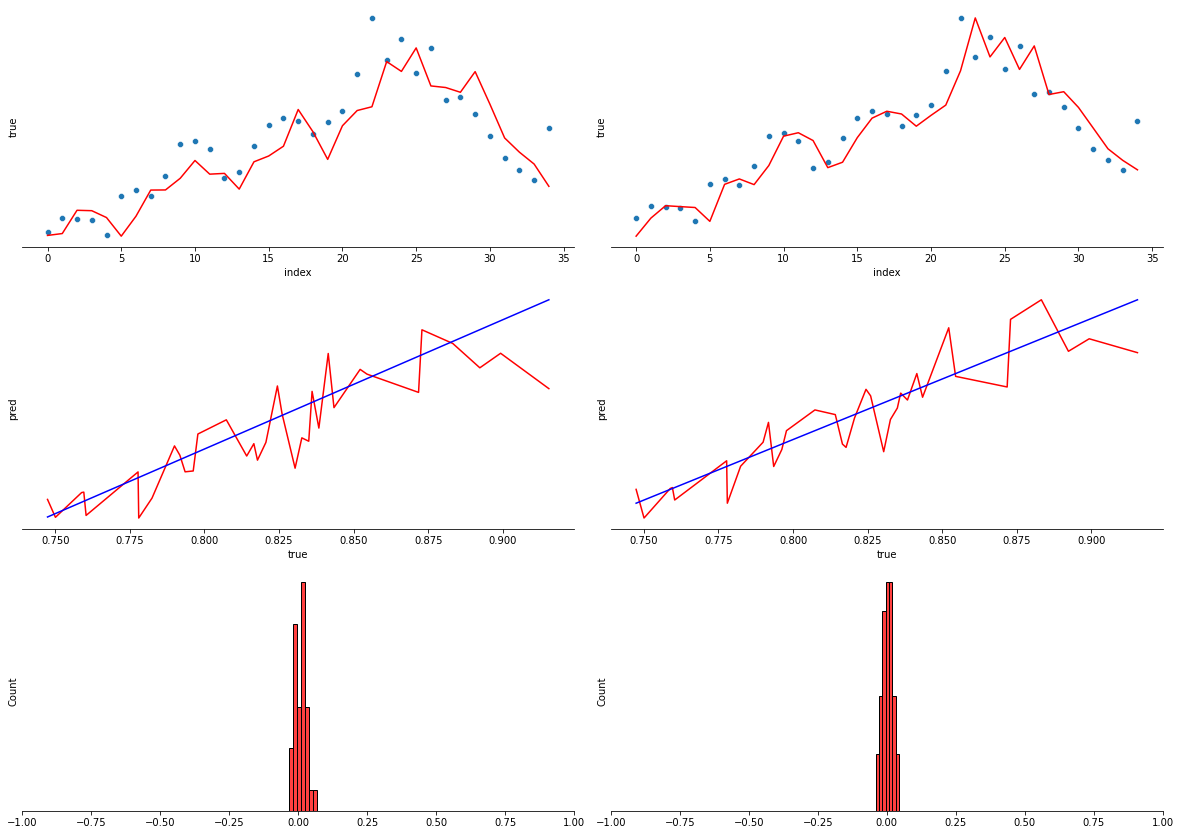

In [11]:
# Evaluate test dataset graphically
graphical_evaluation(test_true, test_pred, bmk_true, bmk_pred)

#### Train and validation datasets

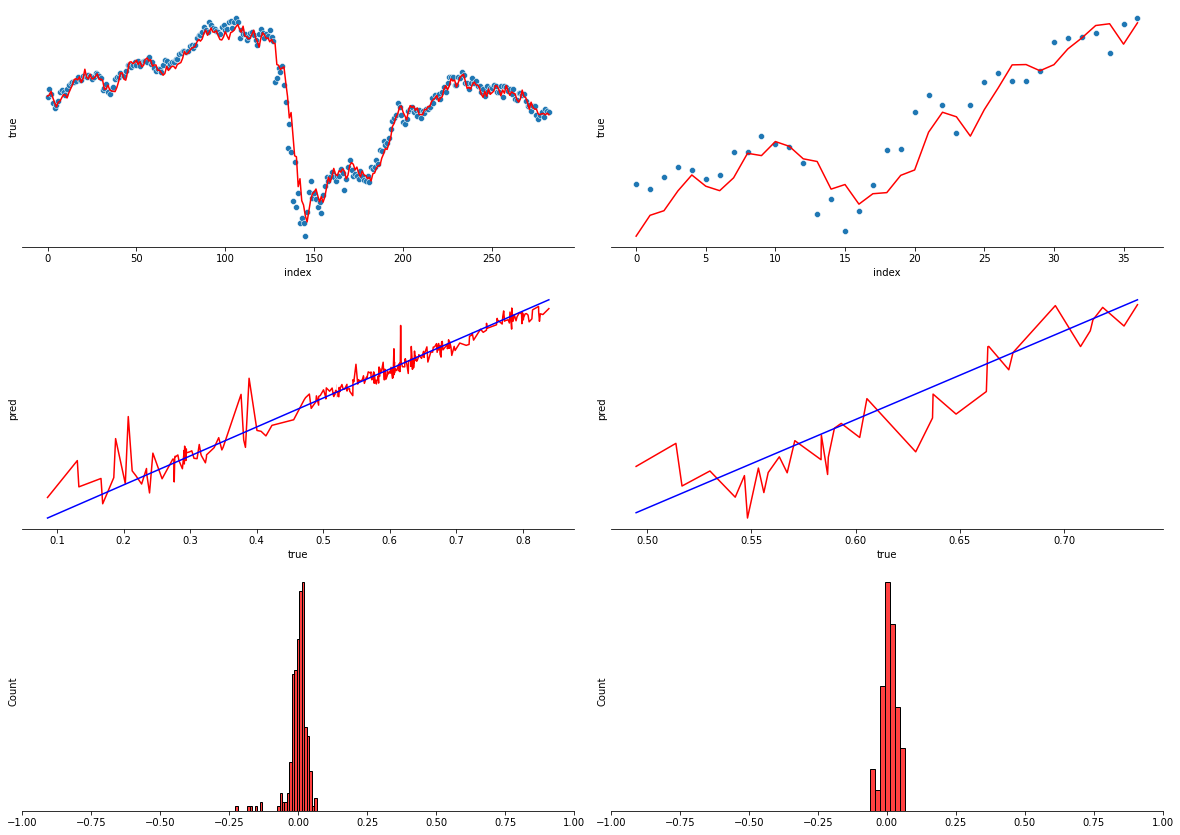

In [12]:
# Evaluate train and validation dataset graphically
graphical_evaluation(train_true, train_pred, valid_true, valid_pred)